## Setup

In [1]:
import numpy as np
rng = np.random.default_rng()  
import matplotlib.pylab as plt

## Helpful recources

https://hef.ru.nl/~tbudd/mct/lectures/markov_chain_monte_carlo.html

https://hef.ru.nl/~tbudd/mct/lectures/cluster_algorithms.html

## The 2D Ising model
The Ising model is a classical way of describing ferromagnetism using simplified spin-spin interactions. The 2D version of the Ising model considers an $w$ by $w$ square lattice, resulting in $N=w^2$ spin sites. If the lattice is given periodic boundary conditions, as is conventional, each spin will have exactly 4 neighbouring spins. The energy of the system is then given by

$ E = -J \sum_i \sum_j s_i s_j - \mu H \sum^{N}_{i=1} s_i $

where we sum over all spins $s_i$ and their neighbours $s_j$ with exchange energy $J$, magnetic moment $\mu$, and externally applied magnetic field $H$.

The most interesting variable of the system is the relative magnetisation of the complete lattice 

$M = \frac{1}{N}\sum_i^N s_i$

or the expected total magnetisation

$\mathbb{E}[M(\mathbf{s})]=\sum_{s \in\{-1,1\}^N}M(s) p_{\mathbf{s}}(s)$

with $p_{\mathbf{s}}(s)$ the probability mass function. The magnetisation shows a very strong dependence on the temperature as well as the externally applied magnetic field $H$. The magnetisation can also show a high variance. 

The analytical approach to calculate compute these expected values would be to use the probability mass function 

$p_{\mathbf{s}}(s)=\frac{1}{Z} e^{-\beta E}$

with partition function

$Z=\sum_{s \in\{-1,1\}^N} e^{-\beta E}$

and inverse temperature $\beta = \frac{1}{k_bT}$. However, computing this type of partition function quickly becomes arduous or simply infeasible for a lattice with any interesting number of spins, especially if the variance is also high. We thus typically use computational methods to investigate such systems and estimate the magnetisation $M$.

## A Monte Carlo model
The first steps of making the model will be to construct the lattice and several functions that compute essential properties of the system.

In [2]:
def init_lattice(width,type):
    '''Produce an initial lattice with spins. Type 1 gives all spins 1, type 0 gives a random spins, type -1 gives all spins -1. Captures invalid types.'''
    if type == 1:
        lattice = np.ones((width,width)) #All spin 1 
    elif type == 0:
        lattice = rng.integers(0,2,size=(width,width))*2 - 1 # makes a random matrix of 1and 0 then multiplies by 2 and subtracts 1 to make it -1 and 1
    elif type == -1:
        lattice = -np.ones((width,width)) #All spin -1
    else:
        raise ValueError('Invalid type.') #Error message
    return lattice

def neighbouring_sites(i,j,width):
    '''Return the coordinates of the 4 sites adjacent to [i,j] on an width*width lattice. Takes into account periodic boundary conditions.'''
    # We need the one on the left of i, the one on the right of i, the one above j and the one below j
    up = [(i-1)%width,j] #putting negatives in the array will wrap around to the other side
    left = [i,(j-1)%width]#putting negatives in the array will wrap around to the other side

    down = [((i+1)%width),j] #// is integer division so it will wrap around to the other side
    right = [i,((j+1)%width)] #// is integer division so it will wrap around to the other side

    return up,down, left, right

def neighbouring_spins_sum(i,j,lattice,width):
    '''Sums the spins of all neighbours of the spin at [i,j].'''
     # first grab the neighbouring sites coordinates
    up,down,left,right = neighbouring_sites(i,j,width)
    # then sum the spins of the neighbouring sites
    return lattice[up[0],up[1]] + lattice[down[0],down[1]] + lattice[left[0],left[1]] + lattice[right[0],right[1]]


def compute_magnetisation(lattice):
    '''Computes the magnetisation of the lattice.'''
    return (np.sum(lattice))/(lattice.shape[0]**2)
def plot_lattice(lattice,ax,title):
    '''Plot the lattice configuration.'''
    ax.matshow(lattice, vmin=-1, vmax=1, cmap=plt.cm.binary)
    ax.title.set_text(title)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_xticks([])

## The Metropolis-Hastings algorithm
In order to be physically accurate, the transitions rates in our system have to satisfy detailed balance. The Metropolis-Hastings algorithm provides us with a way to select such transition rates without a need for knowing the normalisation of the probability distribution. 

$P(s_i \rightarrow -s_i) = \min \left(1, e^{-(\beta E_{-s_i}-\beta E_{s_i})}\right) = \min \left(1, e^{-\beta \Delta E}\right) = \begin{cases}1 & \text { if } \Delta E \leq 0 \\ e^{-\beta\Delta E} & \text { if } \Delta E > 0 \end{cases}$

where $\Delta E$ is the change in energy of the total lattice.

$\Delta E = 2J s_i \sum_j s_j + 2 \mu H s_i $

With this we can set up way to evolve the system. For convenience, it may be useful to define the interaction energies in terms of $\beta J$ and $\beta \mu H$.

In [3]:
def compute_betaDeltaE(i,j,lattice,width,betaJ,betaMuH):
    '''Computes the energy difference between the old and new state if spin [i,j] would be flipped.'''
    # find delta E
    beta_deltaE = 2*lattice[i,j]*(betaJ*neighbouring_spins_sum(i,j,lattice,width) + betaMuH) #compute the energy difference
    return beta_deltaE

def attempt_spin_flip(lattice,width,betaJ,betaMuH):
    '''Applies the Metropolis-Hastings algorithm to try and flip a spin.'''
    #make a matrix with contains the the probability of a spin flip
    ran_a,ran_b = rng.integers(0,width,size=2) #randomly pick a site
    prob = min(1,np.exp(-compute_betaDeltaE(ran_a,ran_b,lattice,width,betaJ,betaMuH))) #This is the probability of a spin flip

    if prob > np.random.rand():
        lattice[ran_a,ran_b] = -lattice[ran_a,ran_b] #flip the spin
        #I did initially try this with a propbability matrix and then compair each element with a random number this didn't consider the adjacent spins flipping at the same time, which is a problem, so I think this is better, we just need to sample over a larger time, but this is fine.


    return lattice


def evolve_and_plot(lattice,betaJ,betaMuH,plot_times):
    '''Evolves the lattice using the Metropolis-Hastings algorithm and plots the lattice at different times.'''
    #first workout how to evolve the lattice
    #then plot the lattice at different times

    fig, ax = plt.subplots(1,len(plot_times),figsize=(12,4))
    for t in range(plot_times[-1]+1):


        if t in plot_times:
            plot_lattice(lattice,ax[plot_times.index(t)],"t = {}".format(t)) #I want to plot the lattice before the first spin flip.

        lattice = attempt_spin_flip(lattice,lattice.shape[0],betaJ,betaMuH) #call the probability matrix 
        
        
    plt.show()




def evolve_and_compute_M(lattice,betaJ,betaMuH,avg_times):
    '''Evolves the lattice using the Metropolis-Hastings algorithm and returns the average magnetisation computed using different time steps.'''

    Mag_sum = 0 #sum of the magnetisation
    #first evolve the lattice
    for t in range(avg_times[-1]+1):
        lattice = attempt_spin_flip(lattice,lattice.shape[0],betaJ,betaMuH) #call the probability matrix 
 
        if t in avg_times:
            Mag_sum += compute_magnetisation(lattice) #add the magnetisation to the sum

                 
    final_lattice = lattice
    return Mag_sum/len(avg_times), final_lattice #return the average magnetisation

    

    

## Testing the model
Evolve the system and plot it at various time steps to see if it appears to behave properly. Let's first get a feel for what a random lattice really looks like. Consider a system with no coupling $\beta J = 0$ and external magnetic field $\beta \mu H = 0$. Try both starting with a random lattice and a lattice with all spins in one direction.

Ordered lattice


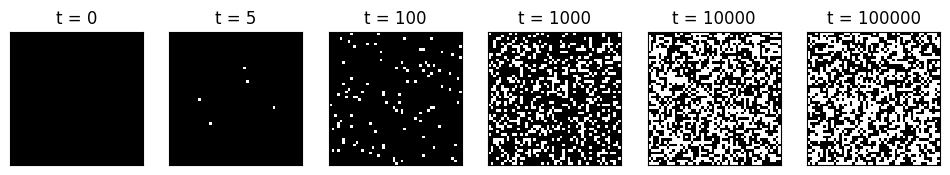

Random lattice


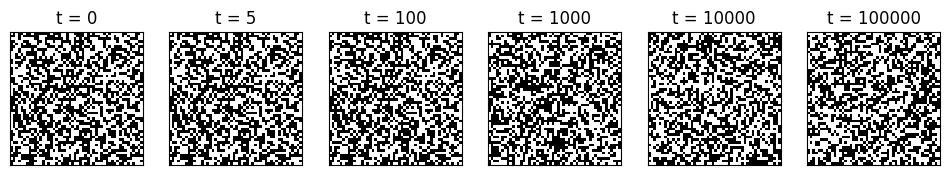

In [4]:
# Testing the Metropolis-Hastings algorithm
plot_times = [0,5,100,1000,10000,100000] #these are the times we want to plot the lattice at.
ran_lattice = init_lattice(50,0)
ordered_lattice = init_lattice(50,1)
print('Ordered lattice')
evolve_and_plot(ordered_lattice,0,0,plot_times)
print('Random lattice')
evolve_and_plot(ran_lattice,0,0,plot_times)

# I'm setting betaJ = betaMuH = 0 so that the spins don't flip. The delta E is always 0 therefore the probability of a spin flip is always 1.

## Limiting case 1: only an external field
When $beta J=0$ there is no coupling. In such a case, only thermal motion and the external magnetic field affect the flipping of the spins. Do a few simulations with $-3 < \beta \mu H < 3$ and observe what happends. Again try both starting with a random lattice and a lattice with all spins in one direction. Qualitatively explain the system behaviour.

Ordered lattice with betaMuH = -3.0, beatJ = 0


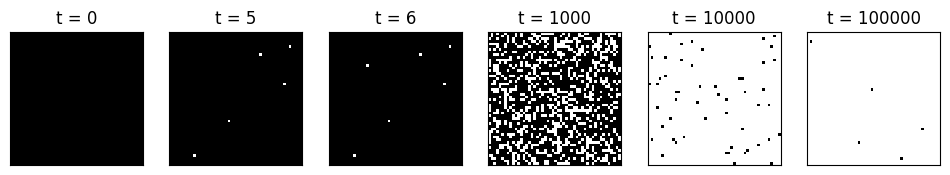

Ordered lattice with betaMuH = -1.0, beatJ = 0


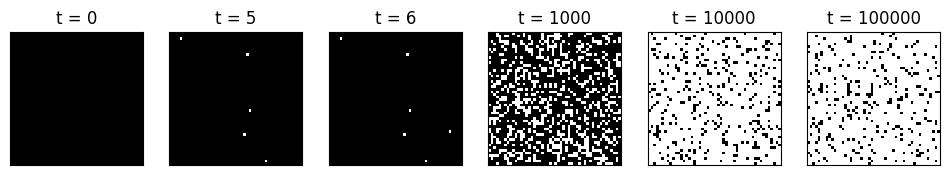

Ordered lattice with betaMuH = 1.0, beatJ = 0


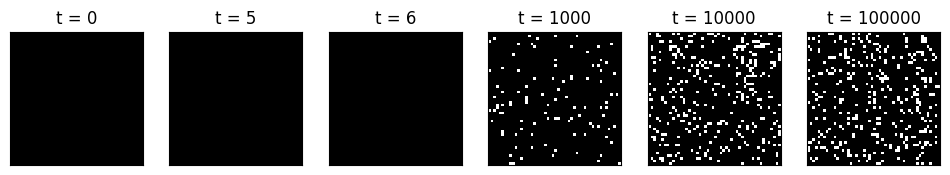

Ordered lattice with betaMuH = 3.0, beatJ = 0


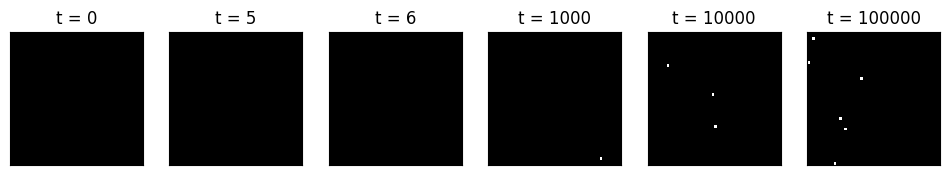

Random lattice with betaMuH = -3.0, beatJ = 0


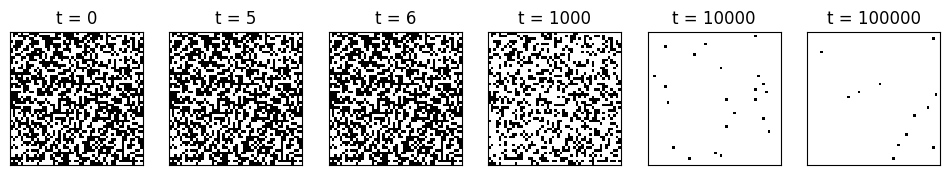

Random lattice with betaMuH = -1.0, beatJ = 0


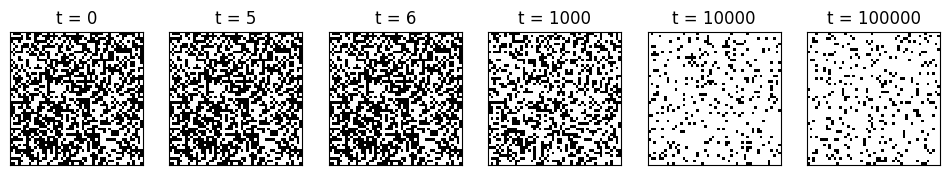

Random lattice with betaMuH = 1.0, beatJ = 0


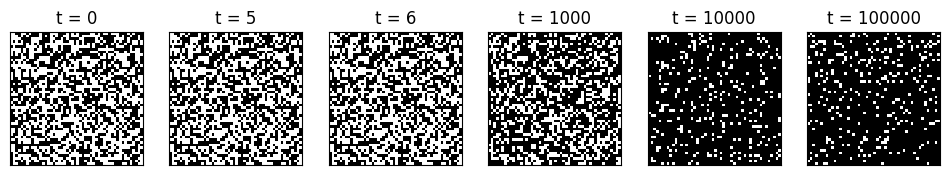

Random lattice with betaMuH = 3.0, beatJ = 0


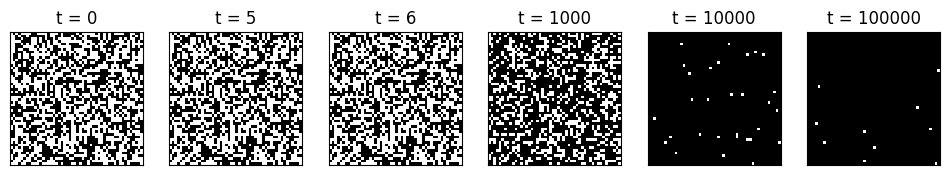

In [5]:
plot_times = [0,5,6,1000,10000,100000]

Beta_H_list = np.linspace(-3,3,4)

for  H in Beta_H_list:
    order_lattice = init_lattice(50,1) #initialise the lattice 
    print(f'Ordered lattice with betaMuH = {H}, beatJ = 0') #title
    evolve_and_plot(order_lattice,0,H,plot_times) #plot the lattice

for  H in Beta_H_list:
    random_lattice = init_lattice(50,0) #initialise the lattice
    print(f'Random lattice with betaMuH = {H}, beatJ = 0') #title
    evolve_and_plot(random_lattice,0,H,plot_times) #plot the lattice



What's happening here is h is the external magnetic field, so the spins are aligning with the magnetic field to reduce the overall energy of the system. The stronger the field the more spins couple to the field for a given number of time steps.

In the case of no coupling, an analytical expression for the mean magnetisation $\langle M\rangle$ exists. The expression is:

$\langle M\rangle = \tanh \left(\beta \mu H \right)$

Show that the Monte Carlo method correctly repoduces the above analytical formula.

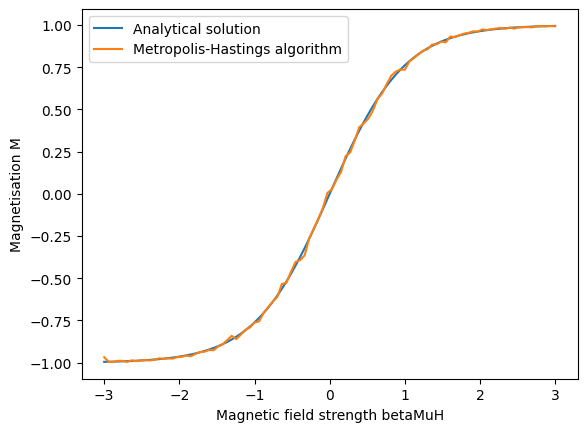

In [6]:
random_lattice = init_lattice(50,0) #random lattice
order_lattice = init_lattice(10,1) #ordered lattice

betaMuHs_analytical = np.linspace(-3,3,100) # betaMuH values to plot
M_analytical = np.tanh(betaMuHs_analytical) # analytical solution for the magnetisation
plt.plot(betaMuHs_analytical,M_analytical,label='Analytical solution')
avg_times = np.array([0,100,200,300,400,500]) + 9900 # time to compute the average magnetisation

M_values = []
for H in betaMuHs_analytical:
    M_values.append(evolve_and_compute_M(random_lattice,0,H,avg_times)[0])


plt.plot(betaMuHs_analytical,M_values,label='Metropolis-Hastings algorithm')

plt.xlabel ('Magnetic field strength betaMuH')
plt.ylabel ('Magnetisation M')
plt.legend(loc='upper left')
plt.show()

Yeah, this is fine

## Limiting case 2: only coupling

Now let us investigate coupling without an external magnetic field. Try the same as previously, using different starting conditions, but introduce some ferromagnetic coupling ($\beta J = 0.2$) or anti-ferromagnetic coupling ($\beta J = -0.2$). Qualitatively explain the system behaviour.

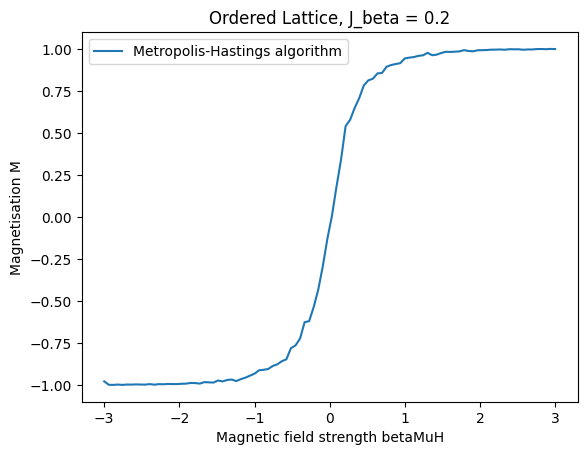

Ordered Lattice, J_beta 0.2 and betaMuH -3.0


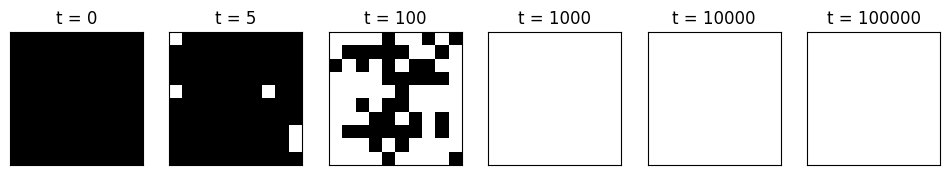

Ordered Lattice, J_beta 0.2 and betaMuH 0.0


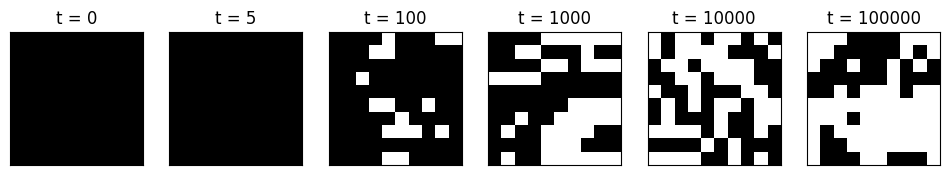

Ordered Lattice, J_beta 0.2 and betaMuH 3.0


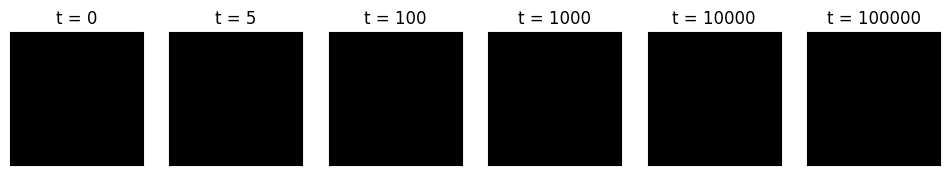

Ordered Lattice, J_beta -0.2 and betaMuH -3.0


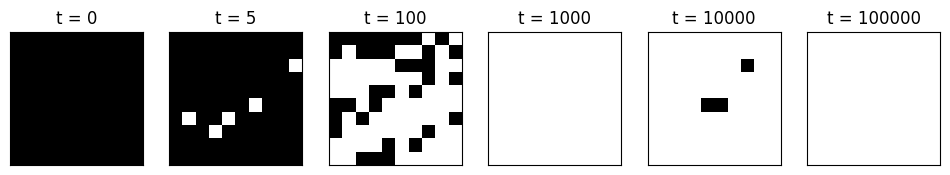

Ordered Lattice, J_beta -0.2 and betaMuH 0.0


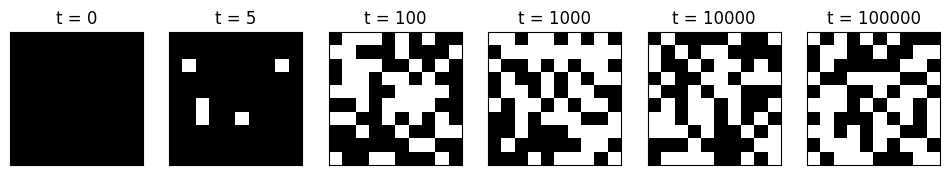

Ordered Lattice, J_beta -0.2 and betaMuH 3.0


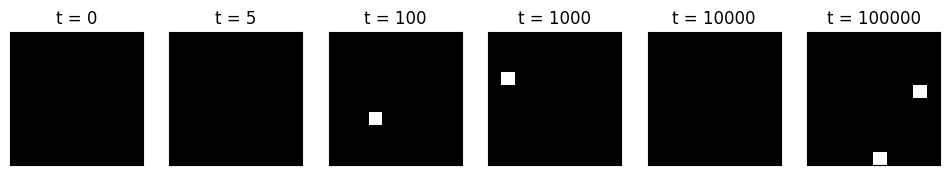

Random Lattice, J_beta 0.2 and betaMuH -3.0


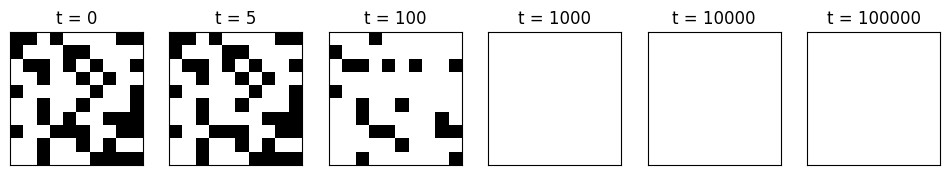

Random Lattice, J_beta 0.2 and betaMuH 0.0


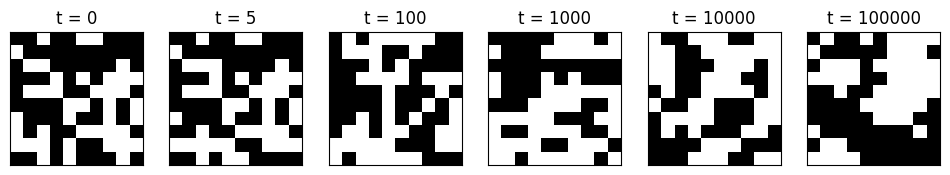

Random Lattice, J_beta 0.2 and betaMuH 3.0


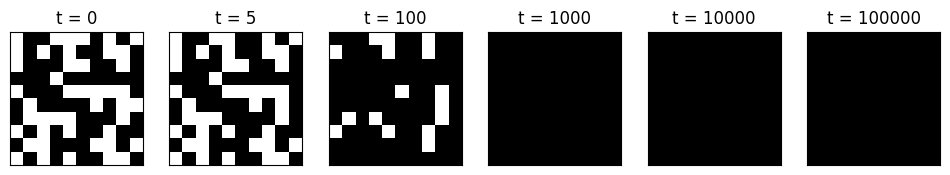

Random Lattice, J_beta -0.2 and betaMuH -3.0


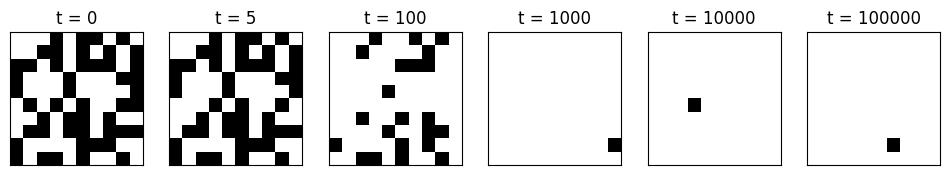

Random Lattice, J_beta -0.2 and betaMuH 0.0


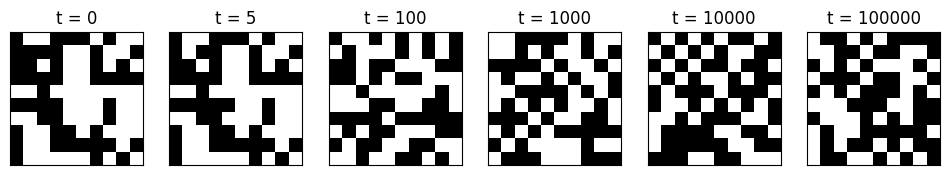

Random Lattice, J_beta -0.2 and betaMuH 3.0


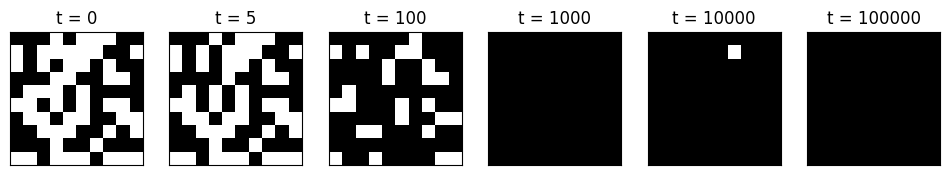

Ordered lattice with betaMuH = 0, betaJ = 0.2


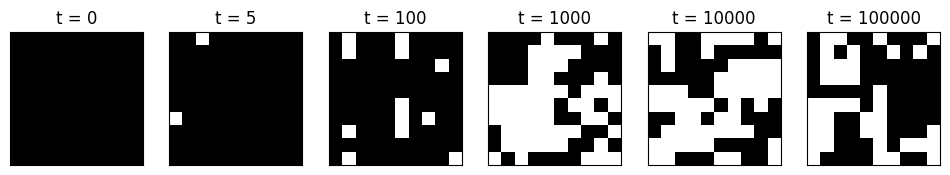

Random lattice with betaMuH = 0, betaJ = 0.2


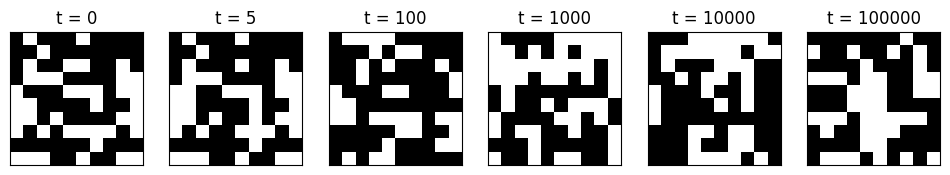

Ordered lattice with betaMuH = 0, betaJ = -0.2


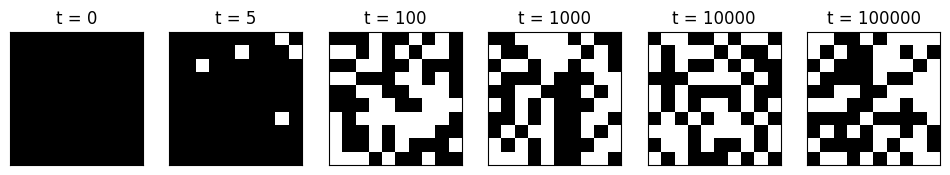

Random lattice with betaMuH = 0, betaJ = -0.2


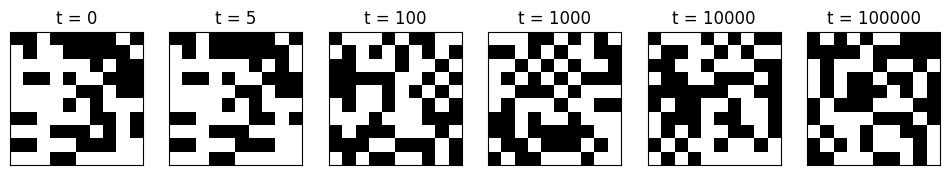

In [7]:
# Testing the Metropolis-Hastings algorithm with ferromagnetic interactions
random_lattice = init_lattice(10,0) #random lattice
order_lattice = init_lattice(10,1) #ordered lattice

J_beta = 0.2 #Change this to minus 0.2 to see the effect of antiferromagnetic interactions


betaMuHs_values = np.linspace(-3,3,100) # betaMuH values to plot
avg_times = np.array([0,100,200,300,400,500]) + 9900# times to compute the average magnetisation

M_values = []
for H in betaMuHs_values:
    order_lattice = init_lattice(10,1) #ordered lattice I can initialise a new lattice each time, but I don't need to.
    M_values.append(evolve_and_compute_M(ordered_lattice,J_beta,H,avg_times)[0])




plt.plot(betaMuHs_values,M_values,label='Metropolis-Hastings algorithm')

plt.xlabel ('Magnetic field strength betaMuH')
plt.ylabel ('Magnetisation M')
plt.legend(loc='upper left')
plt.title(f'Ordered Lattice, J_beta = {J_beta}')
plt.show()
#This isn't that useful

# Imshow plots
plot_times = [0,5,100,1000,10000,100000]


#evolve_and_plot(ordered_lattice,0.2,0,plot_times)

order_lattice = init_lattice(10,1)

#evolve_and_plot(ordered_lattice,-0.2,0,plot_times)

J_beta_list = [0.2,-0.2]
betaMuHs_list = np.linspace(-3,3,3)

for J in J_beta_list:
    for H in betaMuHs_list:
        print(f'Ordered Lattice, J_beta {J} and betaMuH {H}')
        lattice_in = init_lattice(10,1)
        evolve_and_plot(lattice_in,J,H,plot_times)

for J in J_beta_list:
    for H in betaMuHs_list:
        print(f'Random Lattice, J_beta {J} and betaMuH {H}')
        lattice_in = init_lattice(10,0)
        evolve_and_plot(lattice_in,J,H,plot_times)

# I also want to plot with 0 external field
order_lattice = init_lattice(10,1)
print('Ordered lattice with betaMuH = 0, betaJ = 0.2')
evolve_and_plot(order_lattice,J_beta,0,plot_times)
ran_lattice = init_lattice(10,0)
print('Random lattice with betaMuH = 0, betaJ = 0.2')
evolve_and_plot(ran_lattice,J_beta,0,plot_times)

order_lattice = init_lattice(10,1)
print('Ordered lattice with betaMuH = 0, betaJ = -0.2')
evolve_and_plot(order_lattice,-1*J_beta,0,plot_times)
ran_lattice = init_lattice(10,0)
print('Random lattice with betaMuH = 0, betaJ = -0.2')
evolve_and_plot(ran_lattice,-1*J_beta,0,plot_times)

When betaJ is 0.2, the system continues to couple with the external field as does the betaJ -0.2, however it is clear to see the difference when H is zero. When betaJ is positive it is favorable for the spins to form domains, so the spins reduce energy by coupling with neighbors, so it's a competition between energy and entropy. When betaJ is negative, it is unfavorable for the spins to couple, so the lattice looks more checkered because it is higher in energy for neighboring spins to be in the same spin state.

Also for this case, no field and only coupling, Lars Onsanger discovered an analytical solution:

$\langle M\rangle= \begin{cases}0 & \text { if } T \geq T_c \\ \pm \left(1-\sinh \left(2 \beta J\right)^{-4}\right)^{\frac{1}{8}} & \text { if } T<T_c\end{cases}$

where $T_c$ is the critical temperature given by

$T_c=\frac{2 J}{k_b \ln (1+\sqrt{2})}$

Show again that the Monte Carlo method correctly repoduces the above analytical formula. What do you notice about the system around the critical point?

Hint: The system will equilibrate much faster if you start with an initial state that is close to the expected final state.

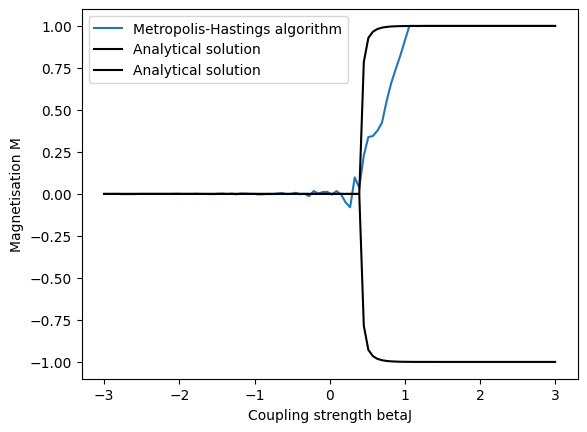

In [8]:
#So this code puts in a random lattice works out the magnetisation for a given beta J, then puts this lattice back in and calculated for the next betaJ. The idea is that the code will be able to pull it's self along the curve as it goes.

betaJ_values = np.linspace(-3,3,100) 

 # analytical solution for the magnetisation
M_analytical_values= []
avg_times = np.array([0,100,200,300,400,500]) + 99000# times to compute the average magnetisation

for J_beta in betaJ_values:
    if J_beta >= np.log(1+np.sqrt(2))/2: # if the coupling is strong enough the system will be ordered
        M_analytical_values.append((1-(np.sinh(2*J_beta))**(-4))**(1/8))   

    else:
        M_analytical_values.append(0)

M_analytical_values_negative = np.array(M_analytical_values)*-1
M_values = []
random_lattice = init_lattice(50,0) #random lattice
for J_beta in betaJ_values:

    to_work_out = evolve_and_compute_M(random_lattice,J_beta,0,avg_times)
 
    M_values.append(to_work_out[0])

    random_lattice = to_work_out[1] # It put in the last lattice used to help it pull itself along.




plt.plot(betaJ_values,M_values,label='Metropolis-Hastings algorithm')

plt.plot(betaJ_values,M_analytical_values,label='Analytical solution',color='black',linestyle='-')
plt.plot(betaJ_values,M_analytical_values_negative,label='Analytical solution',color='black',linestyle='-')


# Simuatle the system at different coupling strengths

plt.xlabel ('Coupling strength betaJ')
plt.ylabel ('Magnetisation M')
plt.legend(loc='upper left')
plt.show()

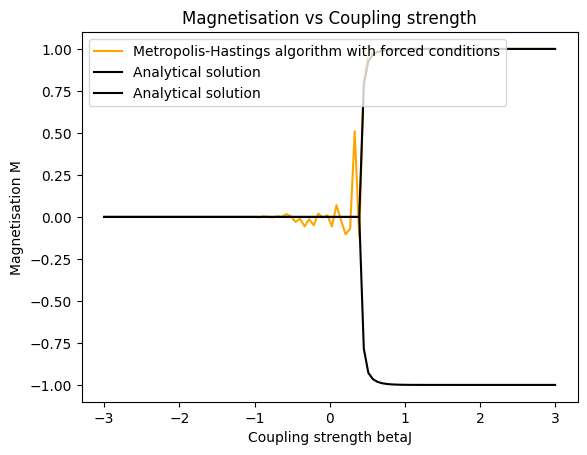

In [9]:
#I'm also going to plug in inital states instead of the code pulling itself along the curve.

betaJ_values = np.linspace(-3,3,100) 

 # analytical solution for the magnetisation
M_analytical_values= []
avg_times = np.array([0,100,200,300,400,500]) + 99000# times to compute the average magnetisation

for J_beta in betaJ_values:
    if J_beta >= np.log(1+np.sqrt(2))/2: # if the coupling is strong enough the system will be ordered
        M_analytical_values.append((1-(np.sinh(2*J_beta))**(-4))**(1/8))   

    else:
        M_analytical_values.append(0)

M_analytical_values_negative = np.array(M_analytical_values)*-1


M_values_forced_IC = []
num_sites = 10
for J_beta in betaJ_values:
    if J_beta >= np.log(1+np.sqrt(2))/2:
        inital_matrix = init_lattice(num_sites,1)
    else:
        inital_matrix = init_lattice(num_sites,0)

    to_work_out = evolve_and_compute_M(inital_matrix,J_beta,0,avg_times)
 
    M_values_forced_IC.append(to_work_out[0])

plt.plot(betaJ_values,M_values_forced_IC,label='Metropolis-Hastings algorithm with forced conditions',color='orange')

plt.plot(betaJ_values,M_analytical_values,label='Analytical solution',color='black',linestyle='-')
plt.plot(betaJ_values,M_analytical_values_negative,label='Analytical solution',color='black',linestyle='-')



plt.xlabel ('Coupling strength betaJ')
plt.ylabel ('Magnetisation M')
plt.legend(loc='upper left')
plt.title('Magnetisation vs Coupling strength')
plt.show()


## Optional: implement the Wolff algorithm
**One more non-optional exercise after this, please look ahead.** In some cases, as you might realise in the next exercise, it can take quite long for the Metropolis-Hastings algorithm to sample the state space of the system. The Wolff algorithm was developed to speed up the exploration of the state space by flipping multiple spins (of the same sign) at once.

The algorithm works as follows:

- Select a spin $s_i$ at random

- Start checking all neighbouring spins $s_j$

- Add a neighbouring spin $s_j$ to the cluster with probability $P_{add} = 1-\exp(-\beta \Delta E)$, but only if it has the same sign as $s_i$

- Repeat until no unvisited neighbours remain

- Flip all spins

Implement Wolff algorithm and compare the equilibration speed to that of the Metropolis-Hastings algorithm for a system with only coupling ($\beta J=0.2$). Hint: In practice it is more convenient to already flip all visited spins.

For the interested reader, an even more efficient method is the Swendsen-Wang algorithm (https://en.wikipedia.org/wiki/Swendsen%E2%80%93Wang_algorithm).

In [10]:
def spin_flip_wolff(lattice,width,betaJ,betaMuH):
    '''Applies the Wolff algorithm to try and flip a spin.'''
    i,j = rng.integers(0,width,2) # Select a random seed
    # TO DO
    unvisited = # TO DO
    while (len(unvisited)>0):   # while unvisited sites remain
        i,j = unvisited.pop(0)  # take one and remove from the unvisited list
        for x,y in neighbouring_sites(i,j,width):
            # TO DO
    return cluster_size

def evolve_and_plot_wolff(lattice,betaJ,betaMuH,plot_times):
    '''Evolves the lattice using the Wolff algorithm and plots the lattice at different times.'''
    # TO DO
    fig, ax = plt.subplots(1,len(plot_times),figsize=(12,4))
    for t in range(plot_times[-1]+1):
        # TO DO
        if t in plot_times:
            plot_lattice(lattice,ax[plot_times.index(t)],"t = {}".format(t))
    plt.show()

SyntaxError: invalid syntax (1505318849.py, line 5)

In [ ]:
# Testing the Wolff algorithm if it has been implemented

# TO DO

## Mandatory: Magnetic susceptibility
A common problem in physical simulations is that we are limited in the size of the systems that we can simulate within a reasonable time. Periodic boundary conditions are typically a good way of circumventing problems caused by finite systems, but some problems cannot be circumvented that easily. The magnetisation of the 2D Ising model shows a continuous phase transition, and statistical physics tells us the correlation length $\xi$ of the system thus follows the relation

$\xi \sim\left|T-T_c\right|^{-\nu}$

with $\nu$ is called the critical exponent. This means that the correlation length will quickly diverge near the critical point and correlate most, if not all, spins in the system with each other. This strongly affects the magnetic susceptibility $\chi$ that is defined as

$\chi=\frac{1}{N} \frac{\partial M}{\partial H}=\frac{\beta}{N}\left(\left\langle M^2\right\rangle-\langle M \rangle^2\right)$.

Run a number of tests to see how the magnetic susceptibility $\chi$ changes as the critical temperature of the system is approached. Repeat this for a smaller or larger lattice. What does this tell you about our ability to get accurate average properties for the system near the critical temperature?

Note: It is more convenient to use the definition of magnetic susceptibility that uses the variance of the magnetisation than the definition of the gradient w.r.t. the magnetic field.

In [ ]:
#Chi function
def evolve_and_computeChi(lattice,betaJ,betaMuH,avg_times):
    '''Evolves the lattice using the Metropolis-Hastings algorithm and computes the average magnetisation using different time steps.'''
    
    Mag_sum = 0 #sum of the magnetisation
    Mag_square_sum = 0 #sum of the magnetisation squared
    #first evolve the lattice
    for t in range(avg_times[-1]+1):
        lattice = attempt_spin_flip(lattice,lattice.shape[0],betaJ,betaMuH) #call the probability matrix 
 
        if t in avg_times:
            Mag_sum += compute_magnetisation(lattice) #add the magnetisation to the sum
            Mag_square_sum += compute_magnetisation(lattice)**2 #add the magnetisation squared to the sum

        chi = ((Mag_square_sum/len(avg_times))-((Mag_sum/len(avg_times))**2))*betaJ#/(lattice.shape[0]**2) #check what N is DO WE NEED 1/N, I'm taking it out
    output_lattice = lattice
    return chi,output_lattice #return the average magnetisation and the last lattice used to help it pull itself along
    

In [ ]:

# Simulate the system at different coupling strengths (relative to the critical temperature)
avg_times = np.array([10000,20000,40000,50000])
betaJ_values = np.linspace(-3,3,100)
relative_betaJ_values = betaJ_values / (np.log(1+np.sqrt(2))/2) # relative to the critical temperature
chi_values = []
inital_lattice = init_lattice(10,0) #random lattice
for J_beta in betaJ_values:
    to_work_out = evolve_and_computeChi(inital_lattice,J_beta,0,avg_times)
    chi_values.append(to_work_out[0])
    inital_lattice = to_work_out[1] # It put in the last lattice used to help it pull itself along.

plt.plot(relative_betaJ_values,chi_values,label='Metropolis-Hastings algorithm')
plt.xlabel ('Coupling strength betaJ')
plt.ylabel ('Magnetic susceptibility Chi')
plt.title('Magnetic susceptibility vs Coupling strength')
plt.show()

In [ ]:
#Instead of "pulling itself along" Im going to try giving it initial conditions everytime
avg_times = np.array([10000,20000,40000,50000])
betaJ_values = np.linspace(-3,3,100)
relative_betaJ_values = betaJ_values / (np.log(1+np.sqrt(2))/2) # relative to the critical temperature
chi_values = []
inital_lattice = init_lattice(50,0) #random lattice
for J_beta in betaJ_values:
    to_work_out = evolve_and_computeChi(inital_lattice,J_beta,0,avg_times)
    chi_values.append(to_work_out[0])
    #Here's the difference
    if J_beta >= np.log(1+np.sqrt(2))/2:
        inital_lattice = init_lattice(10,1) #ordered lattice
    else:
        inital_lattice = init_lattice(10,0) #random lattice

plt.plot(relative_betaJ_values,chi_values,label='Metropolis-Hastings algorithm')
plt.xlabel ('Coupling strength betaJ')
plt.ylabel ('Magnetic susceptibility Chi')
plt.title('Magnetic susceptibility vs Coupling strength')
plt.show()

The two methods give very similar results.

In [ ]:
# Smaller or larger lattice to show susceptibility changes

# Simulate the system at different coupling strengths (relative to the critical temperature)

avg_times = np.array([0,100,200,300,400,500]) + 9900

betaJ_values = np.linspace(-3,3,100)
relative_betaJ_values = betaJ_values/(np.log(1+np.sqrt(2))/2) # relative to the critical temperature
lattice_sizes = np.linspace(10,30,4,dtype=int)
for size in lattice_sizes:
    chi_values = []
    inital_lattice = init_lattice(size,0) #random lattice
    for J_beta in betaJ_values:
        to_work_out = evolve_and_computeChi(inital_lattice,J_beta,0,avg_times)
        chi_values.append(to_work_out[0])
        inital_lattice = to_work_out[1] # It put in the last lattice used to help it pull itself along.
    plt.plot(relative_betaJ_values,chi_values,label=f'Lattice size = {size}')


plt.xlabel ('Coupling strength betaJ')
plt.ylabel ('Magnetic susceptibility Chi')
plt.legend()
plt.title('Magnetic susceptibility as a function of coupling strength for different lattice sizes')
plt.show()

In [ ]:
#Again do it by pluging in the initial conditions

# Simulate the system at different coupling strengths (relative to the critical temperature)

avg_times = np.array([0,100,200,300,400,500]) + 9900

betaJ_values = np.linspace(-3,3,100)
relative_betaJ_values = betaJ_values/(np.log(1+np.sqrt(2))/2) # relative to the critical temperature
lattice_sizes = np.linspace(10,50,10,dtype=int)
for size in lattice_sizes:
    chi_values = []
    inital_lattice = init_lattice(size,0) #random lattice
    for J_beta in betaJ_values:
        to_work_out = evolve_and_computeChi(inital_lattice,J_beta,0,avg_times)
        chi_values.append(to_work_out[0])
        #plug in the initial conditions
        if J_beta >= np.log(1+np.sqrt(2))/2:
            inital_lattice = init_lattice(size,1) #ordered lattice
        else:
            inital_lattice = init_lattice(size,0) #random lattice
    plt.plot(relative_betaJ_values,chi_values,label=f'Lattice size = {size}')


plt.xlabel ('Coupling strength betaJ')
plt.ylabel ('Magnetic susceptibility Chi')
# Smaller or larger lattice to show susceptibility changes

# Simulate the system at different coupling strengths (relative to the critical temperature)

avg_times = np.array([0,100,200,300,400,500]) + 9900

betaJ_values = np.linspace(-3,3,100)
relative_betaJ_values = betaJ_values/(np.log(1+np.sqrt(2))/2) # relative to the critical temperature
lattice_sizes = np.linspace(10,50,10,dtype=int)
for size in lattice_sizes:
    chi_values = []
    inital_lattice = init_lattice(size,0) #random lattice
    for J_beta in betaJ_values:
        to_work_out = evolve_and_computeChi(inital_lattice,J_beta,0,avg_times)
        chi_values.append(to_work_out[0])
        inital_lattice = to_work_out[1] # It put in the last lattice used to help it pull itself along.
    plt.plot(relative_betaJ_values,chi_values,label=f'Lattice size = {size}')


plt.xlabel ('Coupling strength betaJ')
plt.ylabel ('Magnetic susceptibility Chi')
plt.legend()
plt.title('Magnetic susceptibility vs coupling strength for different lattice sizes, forcing the initial conditions')
plt.show()
plt.legend()


So as we increase N (the size of the lattice) the noise deceases, the peak is less spread out, which agrees with the theory but, it does look like the peak loses amplitude, but I think this is due to python struggling to calculate the gradient as it tends towards a delta function, to improve the accuracy I would have to tend the space between the betaJ values to 0, as we decrease the space between the betaJ values it would take longer and longer to run the code. 

## Optional: Further assignments

**Investigate finite-size scaling of the lattice.** The critical temperature varies as a function of the lattice size $N=w*w$

$T_c(N) = T_c(\infty)+aN^{-1/b}$

with $a$ and $b$ being constants to estimate. Compare your estimated $T_c(\infty)$ to Onsanger's analytical result.

**Compute the decorrelation time of the magnetisation to determine the proper equilibration time.** The autovariance is defined as

$A(\tau)=\langle M'(t)M'(t+\tau) \rangle$

where $M'=M-\langle M \rangle$ and $\tau$ is the lag time. The autocorrelation is then given by $a(\tau)=\frac{A(\tau)}{A(0)}$. The decorrelation time can them be said to be $\tau$ for which $a(\tau)$ has dropped to $1/e$.

**Determine the heat capacity.** The fluctuation dissipation theorem states that the heat capacity of the system is given by

$C=\frac{\sigma_E}{k_B T^2} $

with $\sigma_E$ being the standard deviation in the system energy.